In [113]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from pathlib import Path
from datetime import date, timedelta
import re
import multiprocessing as mult
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from joblib import dump, load
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from wordfreq import word_frequency

In [2]:
data = pd.read_feather('data_proc_ver_2.feather')

In [3]:
data = data.drop_duplicates(subset=['Game', 'Username'], keep = 'first')

In [4]:
data

index  level_0  Game  Trial         Username  \
0              0        0   196      1     adamhorsfall   
1              1        1   196      1     TheRealPembo   
2              2        2   196      1           grenow   
3              3        3   196      1         Yummhh__   
4              4        4   196      1  TowerGuardGames   
...          ...      ...   ...    ...              ...   
6923123  6923123  6954101   515      7     moona_moony_   
6923124  6923124  6954102   515      7       JonMDexter   
6923125  6923125  6954103   515      7       KuronaNuva   
6923126  6923126  6954104   515      7           KZYONE   
6923127  6923127  6954105   515      7       Robtrinity   

                                     processed_text target  
0                                           [🟩🟩🟩🟩🟩]  REBUS  
1                                           [🟩🟩🟩🟩🟩]  REBUS  
2                                           [🟩🟩🟩🟩🟩]  REBUS  
3                                           [🟩🟩🟩🟩🟩]  REBUS  
4                                           [🟩🟩🟩🟩🟩]  REBUS  
...                                             ...    ...  
6923123  [🟨⬜⬜⬜🟨, ⬜🟨🟨⬜⬜, ⬜⬜🟨🟨🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]  BAKER  
6923124  [⬜⬜⬜⬜🟩, ⬜⬜⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩🟩🟩🟩, ⬜🟩🟩🟩🟩]  BAKER  
6923125  [⬜🟨🟨⬜🟨, 🟨🟩🟨⬜⬜, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]  BAKER  
6923126  [🟨🟨🟨⬜⬜, ⬜🟨🟨🟨⬜, ⬜⬜🟨🟨🟨, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]  BAKER  
6923127  [⬜⬜🟨⬜⬜, ⬜🟨🟨⬜🟨, 🟨🟩⬜🟩⬜, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]  BAKER  

[6877046 rows x 7 columns]

## Grouping by user

Since our main goal is to find any relation between the players we shall first analyze the distribution of the dataset by grouping by username.

In [5]:
usercount = data.groupby('Username').size()

In [6]:
usercount.describe()

count    977510.000000
mean          7.035269
std          19.436040
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         295.000000
dtype: float64

It seems that we have a mean of 7 games per username which might be significative but seeing the percentiles and the standard deviation it doesn't seen that we have had much luck and that there are users with a significant bulk of games and that the majority of players only have one game registered in our dataset. Basically our distribution is skewed most prominently in the first quantile.

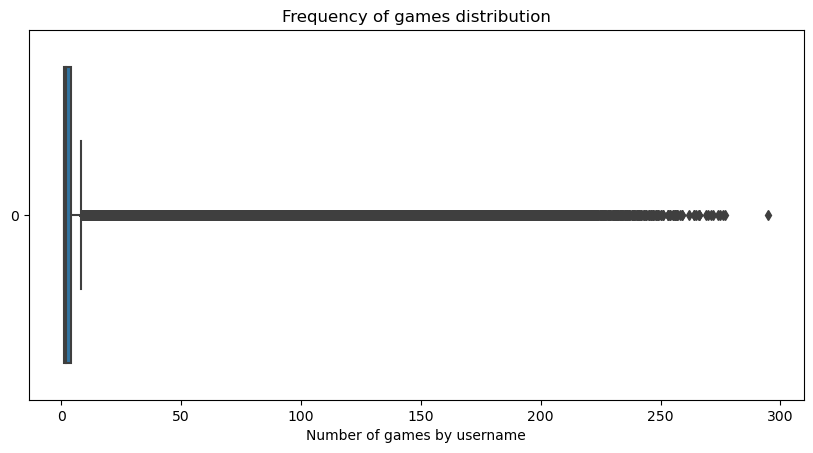

In [7]:
userdist = sns.boxplot(data = usercount, orient = 'h')
userdist.set_xlabel("Number of games by username")
userdist.set_title("Frequency of games distribution");
userdist.figure.set_figwidth(10);

Our suspicions have been confirmed, the distribution is very skewed.

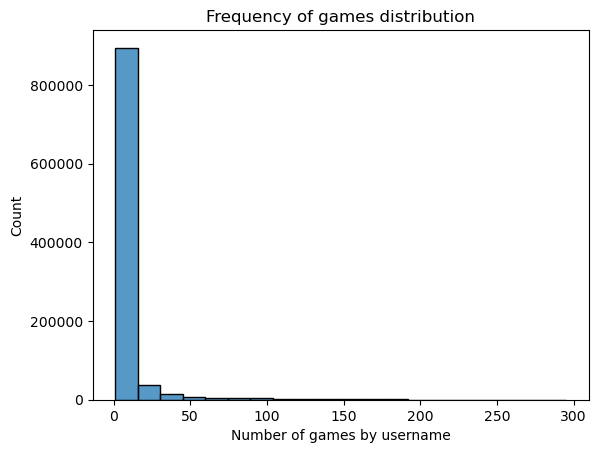

In [8]:
userdist = sns.histplot(data = usercount, bins = 20)
userdist.set_xlabel("Number of games by username")
userdist.set_title("Frequency of games distribution");
#userdist.figure.set_figwidth(60);

### Selecting the most representative candidates

Given this distribution we will first eliminate the first quantile of the set since we deem that one game is not representative enough of a person's behaviour.

In [9]:
userdf = pd.DataFrame()
userdf['Username'] = usercount.index
userdf['games'] = usercount.values

In [10]:
userdf = userdf.loc[userdf['games'] > 7]
userdf.describe()

games
count  153893.000000
mean       33.720501
std        39.262240
min         8.000000
25%        10.000000
50%        17.000000
75%        37.000000
max       295.000000

We seen to still have a very skewed distribution given the standard deviation and the percentiles.

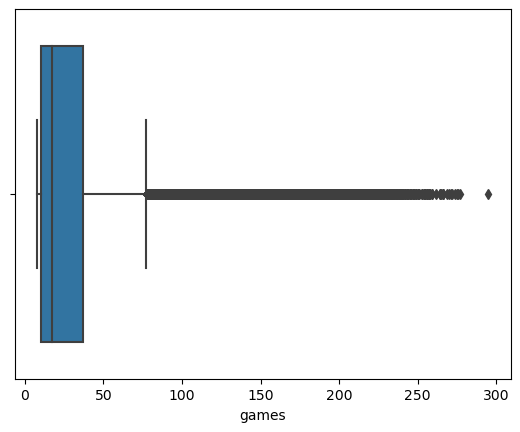

In [11]:
userdist = sns.boxplot(data = userdf, x = 'games')

As we can see after limiting the mininum number of games to 8 there's still quite a lot of points far from the mean.

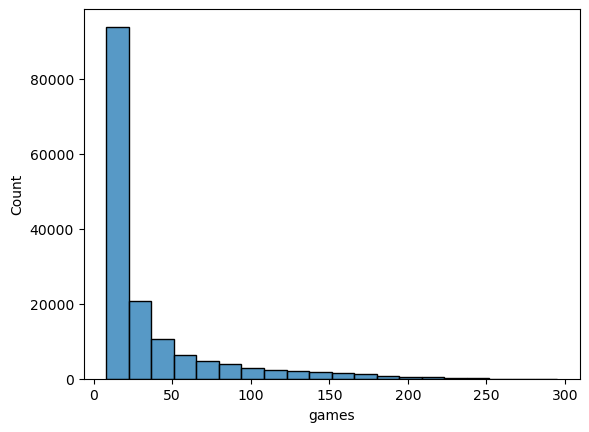

In [12]:
userdist = sns.histplot(data = userdf, x ='games', bins = 20)
#userdist.figure.set_figwidth(60);

Even though we still have skeweness the distribution seems much better. We will use this reduced dataset in our clustering algorithms.

### Generating the values for the kmeans

First we will create a new DataFrame where we will place all the variable that we will use to try to cluster the data.

In [13]:
data['attemps'] = data['Trial'].apply(lambda x: 6 if x == 7 else x)
data['ocurr'] = data.groupby('Username')['Username'].transform('size')
training_data = data.loc[data['ocurr'] > 7]
uservals = pd.DataFrame()
uservals['Username'] = training_data.groupby('Username')['Username'].size().index

### Generating the variables

First we will create some basic variables, the mean length of the game and the average of lost games.

In [14]:
uservals['Mean_length'] = training_data.groupby('Username')['attemps'].mean().values

In [15]:
def findlosses(series):
    loses = 0
    for val in series:
        if val == 7:
            loses +=1
    return loses/len(series)
uservals['Mean_loss'] = training_data.groupby('Username')['Trial'].apply(findlosses).values

In [16]:
#Optional
#def avgcharfirsttry(series, char):
#    total = 0
#    for game in series:
#        total += game[0].count(char)
#    return total/len(series)
#uservals['Mean_green_first'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharfirsttry(x, '🟩')).values
#uservals['Mean_yellow_first'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharfirsttry(x, '🟨')).values
#uservals['Mean_white_first'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharfirsttry(x, '⬜')).values

Now we will find the average number of tiles of a given color for a given user.

In [17]:
def avgcharpergame(series, char):
    avg = 0
    for game in series:
        total = 0
        for attempt in game:
            total += attempt.count(char)
        avg += total/len(game)
    return avg/len(series)
uservals['Mean_green'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharpergame(x, '🟩')).values
uservals['Mean_yellow'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharpergame(x, '🟨')).values
uservals['Mean_white'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgcharpergame(x, '⬜')).values

Finally we will generate the average of the differences between attemps of number of each color tile for each player.

In [18]:
def avgchardiff(series, char):
    avg = 0
    for game in series:
        total = 0
        if len(game) > 1:
            for i in range(0, len(game)-1):
                total += game[i+1].count(char) - game[i].count(char)
            avg += total/(len(game) - 1)
    return avg/len(series)
uservals['Mean_green_diff'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgchardiff(x, '🟩')).values
uservals['Mean_yellow_diff'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgchardiff(x, '🟨')).values
uservals['Mean_white_diff'] = training_data.groupby('Username')['processed_text'].apply(lambda x : avgchardiff(x, '⬜')).values

In [19]:
def meanattemp3(series, char):
    avg = 0
    for game in series:
        if len(game) >= 3:
            avg += game[2].count(char)
        else:
            if char == '🟩':
                avg += 5
    return avg/len(series)
uservals['Mean_green_third'] = training_data.groupby('Username')['processed_text'].apply(lambda x : meanattemp3(x, '🟩')).values
uservals['Mean_yellow_third'] = training_data.groupby('Username')['processed_text'].apply(lambda x : meanattemp3(x, '🟨')).values
uservals['Mean_white_third'] = training_data.groupby('Username')['processed_text'].apply(lambda x : meanattemp3(x, '⬜')).values

In [20]:
uservals

Username  Mean_length  Mean_loss  Mean_green  Mean_yellow  \
0           0000000a77     3.692308   0.076923    2.688462     0.597436   
1               0001mz     3.529412   0.000000    2.211765     0.849020   
2         000Dillinger     3.870370   0.000000    2.249691     0.680556   
3             000GOOBY     3.653846   0.000000    2.463462     0.744231   
4       000lliissaa000     4.923077   0.000000    2.116667     1.016667   
...                ...          ...        ...         ...          ...   
153888       zzzmarie1     4.068966   0.000000    2.399425     0.600000   
153889         zzzoren     4.090909   0.000000    2.336364     0.760354   
153890          zzzsan     5.026316   0.000000    2.353947     0.755263   
153891        zzzymmiT     2.666667   0.000000    2.607407     0.788889   
153892    zzzzqqqq1111     4.257143   0.000000    2.366190     0.567143   

        Mean_white  Mean_green_diff  Mean_yellow_diff  Mean_white_diff  \
0         1.714103         1.312821         -0.224359        -1.088462   
1         1.939216         2.210784         -0.549020        -1.661765   
2         2.069753         1.800617         -0.522840        -1.277778   
3         1.792308         1.974359         -0.407692        -1.566667   
4         1.866667         1.378205         -0.451282        -0.926923   
...            ...              ...               ...              ...   
153888    2.000575         1.608908         -0.295115        -1.313793   
153889    1.903283         1.736869         -0.470707        -1.266162   
153890    1.890789         1.198684         -0.276316        -0.922368   
153891    1.603704         3.194444         -1.138889        -2.055556   
153892    2.066667         1.738571         -0.296667        -1.441905   

        Mean_green_third  Mean_yellow_third  Mean_white_third  
0               3.230769           0.615385          1.153846  
1               3.764706           0.294118          0.941176  
2               3.425926           0.314815          1.259259  
3               3.576923           0.576923          0.846154  
4               2.076923           0.769231          2.153846  
...                  ...                ...               ...  
153888          3.137931           0.482759          1.379310  
153889          2.954545           0.606061          1.439394  
153890          2.210526           1.000000          1.789474  
153891          4.555556           0.111111          0.333333  
153892          3.200000           0.371429          1.428571  

[153893 rows x 12 columns]

In [21]:
uservals.corr()

Mean_length  Mean_loss  Mean_green  Mean_yellow  \
Mean_length           1.000000   0.482679   -0.745821     0.295848   
Mean_loss             0.482679   1.000000   -0.363484     0.110959   
Mean_green           -0.745821  -0.363484    1.000000    -0.591452   
Mean_yellow           0.295848   0.110959   -0.591452     1.000000   
Mean_white            0.749576   0.383319   -0.899487     0.179675   
Mean_green_diff      -0.804946  -0.443787    0.461102    -0.075474   
Mean_yellow_diff      0.639532   0.294183   -0.388522    -0.201238   
Mean_white_diff       0.751935   0.453911   -0.415795     0.246479   
Mean_green_third     -0.892078  -0.376660    0.809317    -0.378637   
Mean_yellow_third     0.678570   0.258703   -0.665059     0.577416   
Mean_white_third      0.869393   0.381686   -0.762772     0.217028   

                   Mean_white  Mean_green_diff  Mean_yellow_diff  \
Mean_length          0.749576        -0.804946          0.639532   
Mean_loss            0.383319        -0.443787          0.294183   
Mean_green          -0.899487         0.461102         -0.388522   
Mean_yellow          0.179675        -0.075474         -0.201238   
Mean_white           1.000000        -0.521641          0.583041   
Mean_green_diff     -0.521641         1.000000         -0.814707   
Mean_yellow_diff     0.583041        -0.814707          1.000000   
Mean_white_diff      0.373701        -0.920531          0.523425   
Mean_green_third    -0.782178         0.778560         -0.624161   
Mean_yellow_third    0.498468        -0.588323          0.474414   
Mean_white_third     0.812969        -0.760810          0.608480   

                   Mean_white_diff  Mean_green_third  Mean_yellow_third  \
Mean_length               0.751935         -0.892078           0.678570   
Mean_loss                 0.453911         -0.376660           0.258703   
Mean_green               -0.415795          0.809317          -0.665059   
Mean_yellow               0.246479         -0.378637           0.577416   
Mean_white                0.373701         -0.782178           0.498468   
Mean_green_diff          -0.920531          0.778560          -0.588323   
Mean_yellow_diff          0.523425         -0.624161           0.474414   
Mean_white_diff           1.000000         -0.723519           0.544868   
Mean_green_third         -0.723519          1.000000          -0.806398   
Mean_yellow_third         0.544868         -0.806398           1.000000   
Mean_white_third          0.708001         -0.950553           0.582865   

                   Mean_white_third  
Mean_length                0.869393  
Mean_loss                  0.381686  
Mean_green                -0.762772  
Mean_yellow                0.217028  
Mean_white                 0.812969  
Mean_green_diff           -0.760810  
Mean_yellow_diff           0.608480  
Mean_white_diff            0.708001  
Mean_green_third          -0.950553  
Mean_yellow_third          0.582865  
Mean_white_third           1.000000

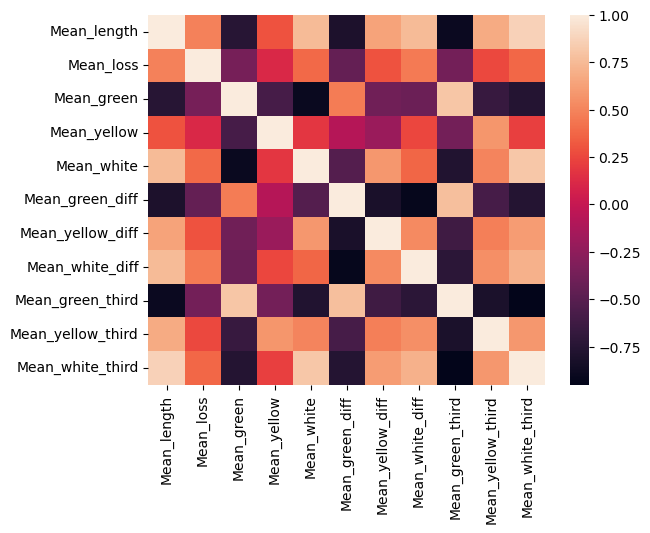

In [22]:
sns.heatmap(uservals.corr());

## Performing a PCA
Due to the vast amount of correlated variables we decided to perform a PCA in order to extract the highest amount of information

In [62]:
features = uservals.loc[:, uservals.columns != 'Username']

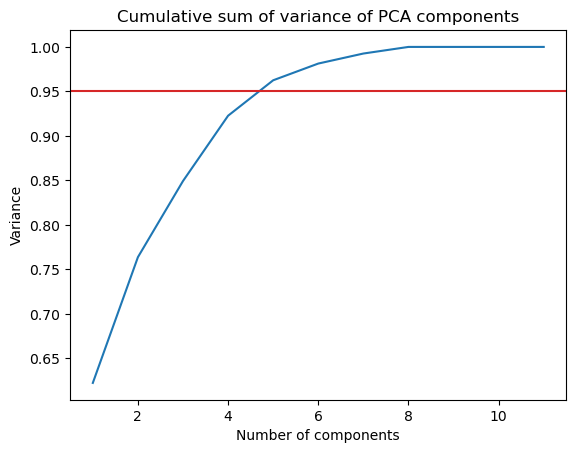

In [64]:
from sklearn.decomposition import PCA
pca = PCA(random_state = 123)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca.fit(scaled_features)
variance_ratio = sns.lineplot(x=range(1,len(features.columns)+1), y = pca.explained_variance_ratio_.cumsum());
variance_ratio.set_xlabel("Number of components")
variance_ratio.set_title("Cumulative sum of variance of PCA components");
variance_ratio.set_ylabel("Variance");
plt.axhline(0.95, color='#d62728');

As we can see we have to take up to 5 components in order to preserve 0.95 of the variance.

In [65]:
features = pca.transform(scaled_features)
features = pd.DataFrame(features)
features = features[[0,1,2,3,4]]

## Clustering

First we will need to standarize our data, then we will perform the necessary transformations to it in order to fit it to the models. We will also create a dictionary containing the parameters for the K-means algorithm.

In [67]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [117]:
#features = uservals.loc[:, uservals.columns != 'Username']
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 123}

In [68]:
sse = []
silhouette_coefficients = []
for i in range(2,10):
    print('----Training for ' + str(i) + ' clusters----')
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    print('Silhoute: ' + str(score))
    print('Inertia: ' + str(kmeans.inertia_))

----Training for 2 clusters----
Silhoute: 0.31113992631101434
Inertia: 1026467.0525641413
----Training for 3 clusters----
Silhoute: 0.2984398376834013
Inertia: 798134.7478489891
----Training for 4 clusters----
Silhoute: 0.23618148427504687
Inertia: 698811.4303229746
----Training for 5 clusters----
Silhoute: 0.20628309958056945
Inertia: 639010.9461210301
----Training for 6 clusters----
Silhoute: 0.2033038165821681
Inertia: 584961.5413929936
----Training for 7 clusters----
Silhoute: 0.19327951079404318
Inertia: 538122.9996277404
----Training for 8 clusters----
Silhoute: 0.18761208754333442
Inertia: 501856.9839810465
----Training for 9 clusters----
Silhoute: 0.19096952890034616
Inertia: 472217.6425287096


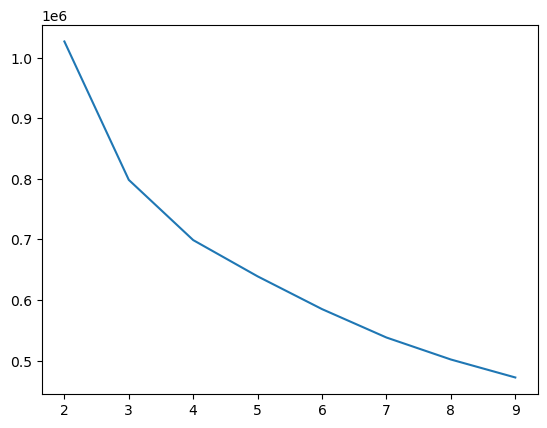

In [69]:
sns.lineplot(x = range(2,10), y = sse)
plt.show()

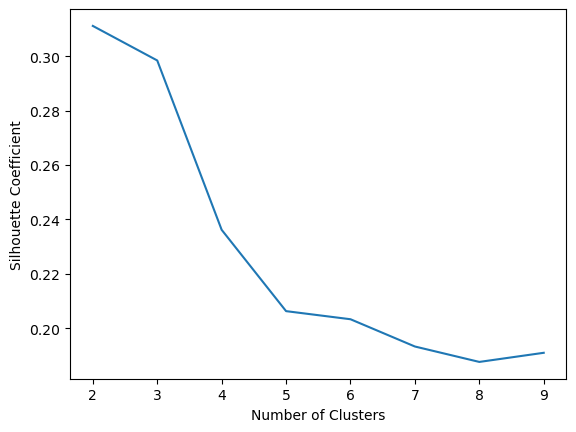

In [70]:
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Clustering with only 3 components

In [76]:
features = features[[0,1,2]]

In [78]:
sse = []
silhouette_coefficients = []
for i in range(2,10):
    print('----Training for ' + str(i) + ' clusters----')
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    print('Silhoute: ' + str(score))
    print('Inertia: ' + str(kmeans.inertia_))

----Training for 2 clusters----
Silhoute: 0.35167048059846523
Inertia: 836295.612898481
----Training for 3 clusters----
Silhoute: 0.33833280138469035
Inertia: 615297.5454619711
----Training for 4 clusters----
Silhoute: 0.2696782945566713
Inertia: 525737.7934995631
----Training for 5 clusters----
Silhoute: 0.2552615326310966
Inertia: 472532.38482151885
----Training for 6 clusters----
Silhoute: 0.23647441367509142
Inertia: 425801.2922123079
----Training for 7 clusters----
Silhoute: 0.23706049047193367
Inertia: 382469.14599688974
----Training for 8 clusters----
Silhoute: 0.23822097935427025
Inertia: 353376.579407729
----Training for 9 clusters----
Silhoute: 0.22901942773278924
Inertia: 329191.57117644115


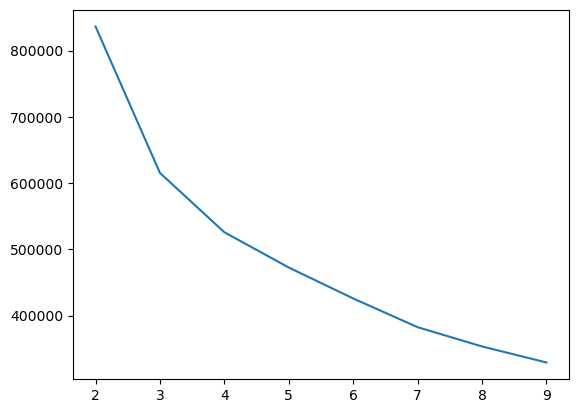

In [79]:
sns.lineplot(x = range(2,10), y = sse)
plt.show()

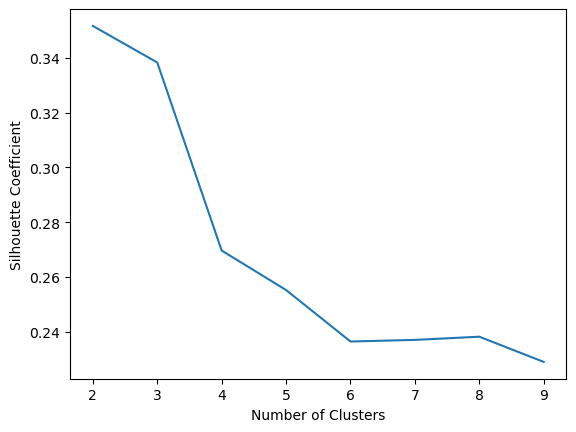

In [80]:
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Clustering with only 2 components

In [81]:
features = features[[0,1]]

In [82]:
sse = []
silhouette_coefficients = []
for i in range(2,10):
    print('----Training for ' + str(i) + ' clusters----')
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    print('Silhoute: ' + str(score))
    print('Inertia: ' + str(kmeans.inertia_))

----Training for 2 clusters----
Silhoute: 0.3965820837092973
Inertia: 691573.7986474963
----Training for 3 clusters----
Silhoute: 0.3914333116964564
Inertia: 470539.7854163336
----Training for 4 clusters----
Silhoute: 0.33303178489530205
Inertia: 381284.2911897795
----Training for 5 clusters----
Silhoute: 0.3251009878343969
Inertia: 327805.67557314737
----Training for 6 clusters----
Silhoute: 0.30812812206875073
Inertia: 283562.1667876317
----Training for 7 clusters----
Silhoute: 0.30989530688671657
Inertia: 249478.6033149319
----Training for 8 clusters----
Silhoute: 0.30584734371966127
Inertia: 223497.00472291745
----Training for 9 clusters----
Silhoute: 0.31168893345458176
Inertia: 203151.75169123884


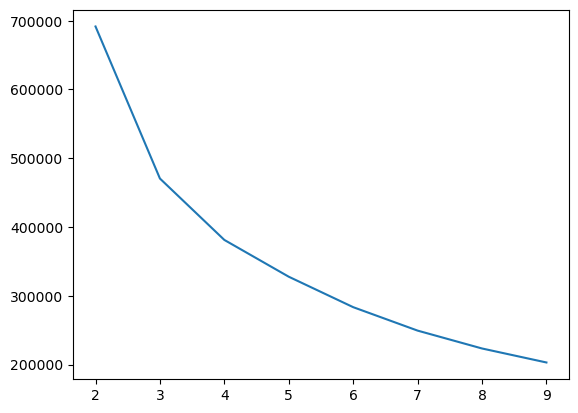

In [83]:
sns.lineplot(x = range(2,10), y = sse)
plt.show()

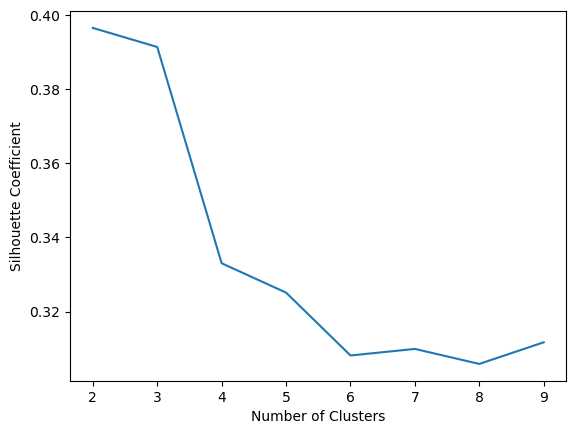

In [84]:
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### Clustering without PCA

In [85]:
uservals.columns

Index(['Username', 'Mean_length', 'Mean_loss', 'Mean_green', 'Mean_yellow',
       'Mean_white', 'Mean_green_diff', 'Mean_yellow_diff', 'Mean_white_diff',
       'Mean_green_third', 'Mean_yellow_third', 'Mean_white_third'],
      dtype='object')

In [86]:
features = uservals[['Mean_length', 'Mean_loss', 'Mean_yellow', 'Mean_white', 'Mean_yellow_diff',
                    'Mean_white_diff', 'Mean_yellow_third']]

In [87]:
features.corr()

Mean_length  Mean_loss  Mean_yellow  Mean_white  \
Mean_length           1.000000   0.482679     0.295848    0.749576   
Mean_loss             0.482679   1.000000     0.110959    0.383319   
Mean_yellow           0.295848   0.110959     1.000000    0.179675   
Mean_white            0.749576   0.383319     0.179675    1.000000   
Mean_yellow_diff      0.639532   0.294183    -0.201238    0.583041   
Mean_white_diff       0.751935   0.453911     0.246479    0.373701   
Mean_yellow_third     0.678570   0.258703     0.577416    0.498468   

                   Mean_yellow_diff  Mean_white_diff  Mean_yellow_third  
Mean_length                0.639532         0.751935           0.678570  
Mean_loss                  0.294183         0.453911           0.258703  
Mean_yellow               -0.201238         0.246479           0.577416  
Mean_white                 0.583041         0.373701           0.498468  
Mean_yellow_diff           1.000000         0.523425           0.474414  
Mean_white_diff            0.523425         1.000000           0.544868  
Mean_yellow_third          0.474414         0.544868           1.000000

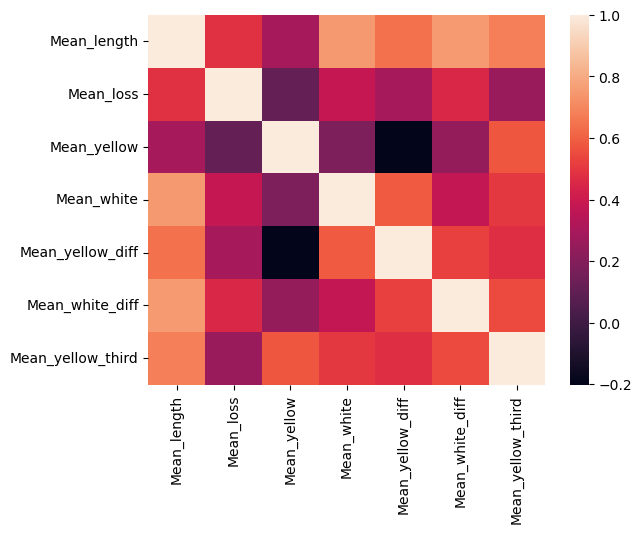

In [88]:
sns.heatmap(features.corr());

In [89]:
#features = uservals.loc[:, uservals.columns != 'Username']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 123}

In [90]:
sse = []
silhouette_coefficients = []
for i in range(2,7):
    print('----Training for ' + str(i) + ' clusters----')
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    print('Silhoute: ' + str(score))
    print('Inertia: ' + str(kmeans.inertia_))

----Training for 2 clusters----
Silhoute: 0.25916791448104887
Inertia: 754754.6956011512
----Training for 3 clusters----
Silhoute: 0.2583147149478455
Inertia: 623122.2844166044
----Training for 4 clusters----
Silhoute: 0.21155021894031864
Inertia: 543180.5181919687
----Training for 5 clusters----
Silhoute: 0.18324164967536125
Inertia: 492023.99692480685
----Training for 6 clusters----
Silhoute: 0.18026837345330088
Inertia: 452270.53749250737


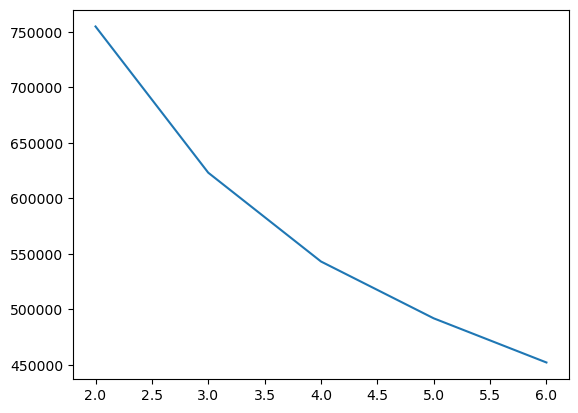

In [91]:
sns.lineplot(x = range(2,7), y = sse)
plt.show()

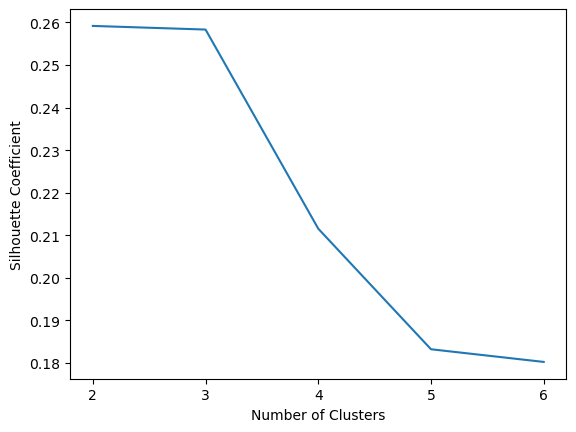

In [92]:
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Feature importance

We will select k = 3, for the PCA with 2 components since it holds the highest silhouette coeffiecient.

In [93]:
features = uservals.loc[:, uservals.columns != 'Username']
from sklearn.decomposition import PCA
pca = PCA(random_state = 123)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca.fit(scaled_features)
features = pca.transform(scaled_features)
features = pd.DataFrame(features)
features = features[[0,1]]
kmeans = KMeans(n_clusters = 3, **kmeans_kwargs)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=123)

We will make sure to store our model.

In [21]:
dump(kmeans, 'kmeansmodel.joblib');

In [97]:
features = uservals.loc[:, uservals.columns != 'Username']
features['labels'] = kmeans.labels_

Now we will compare each feature and hue them by the labels given by the kmeans algorithm.

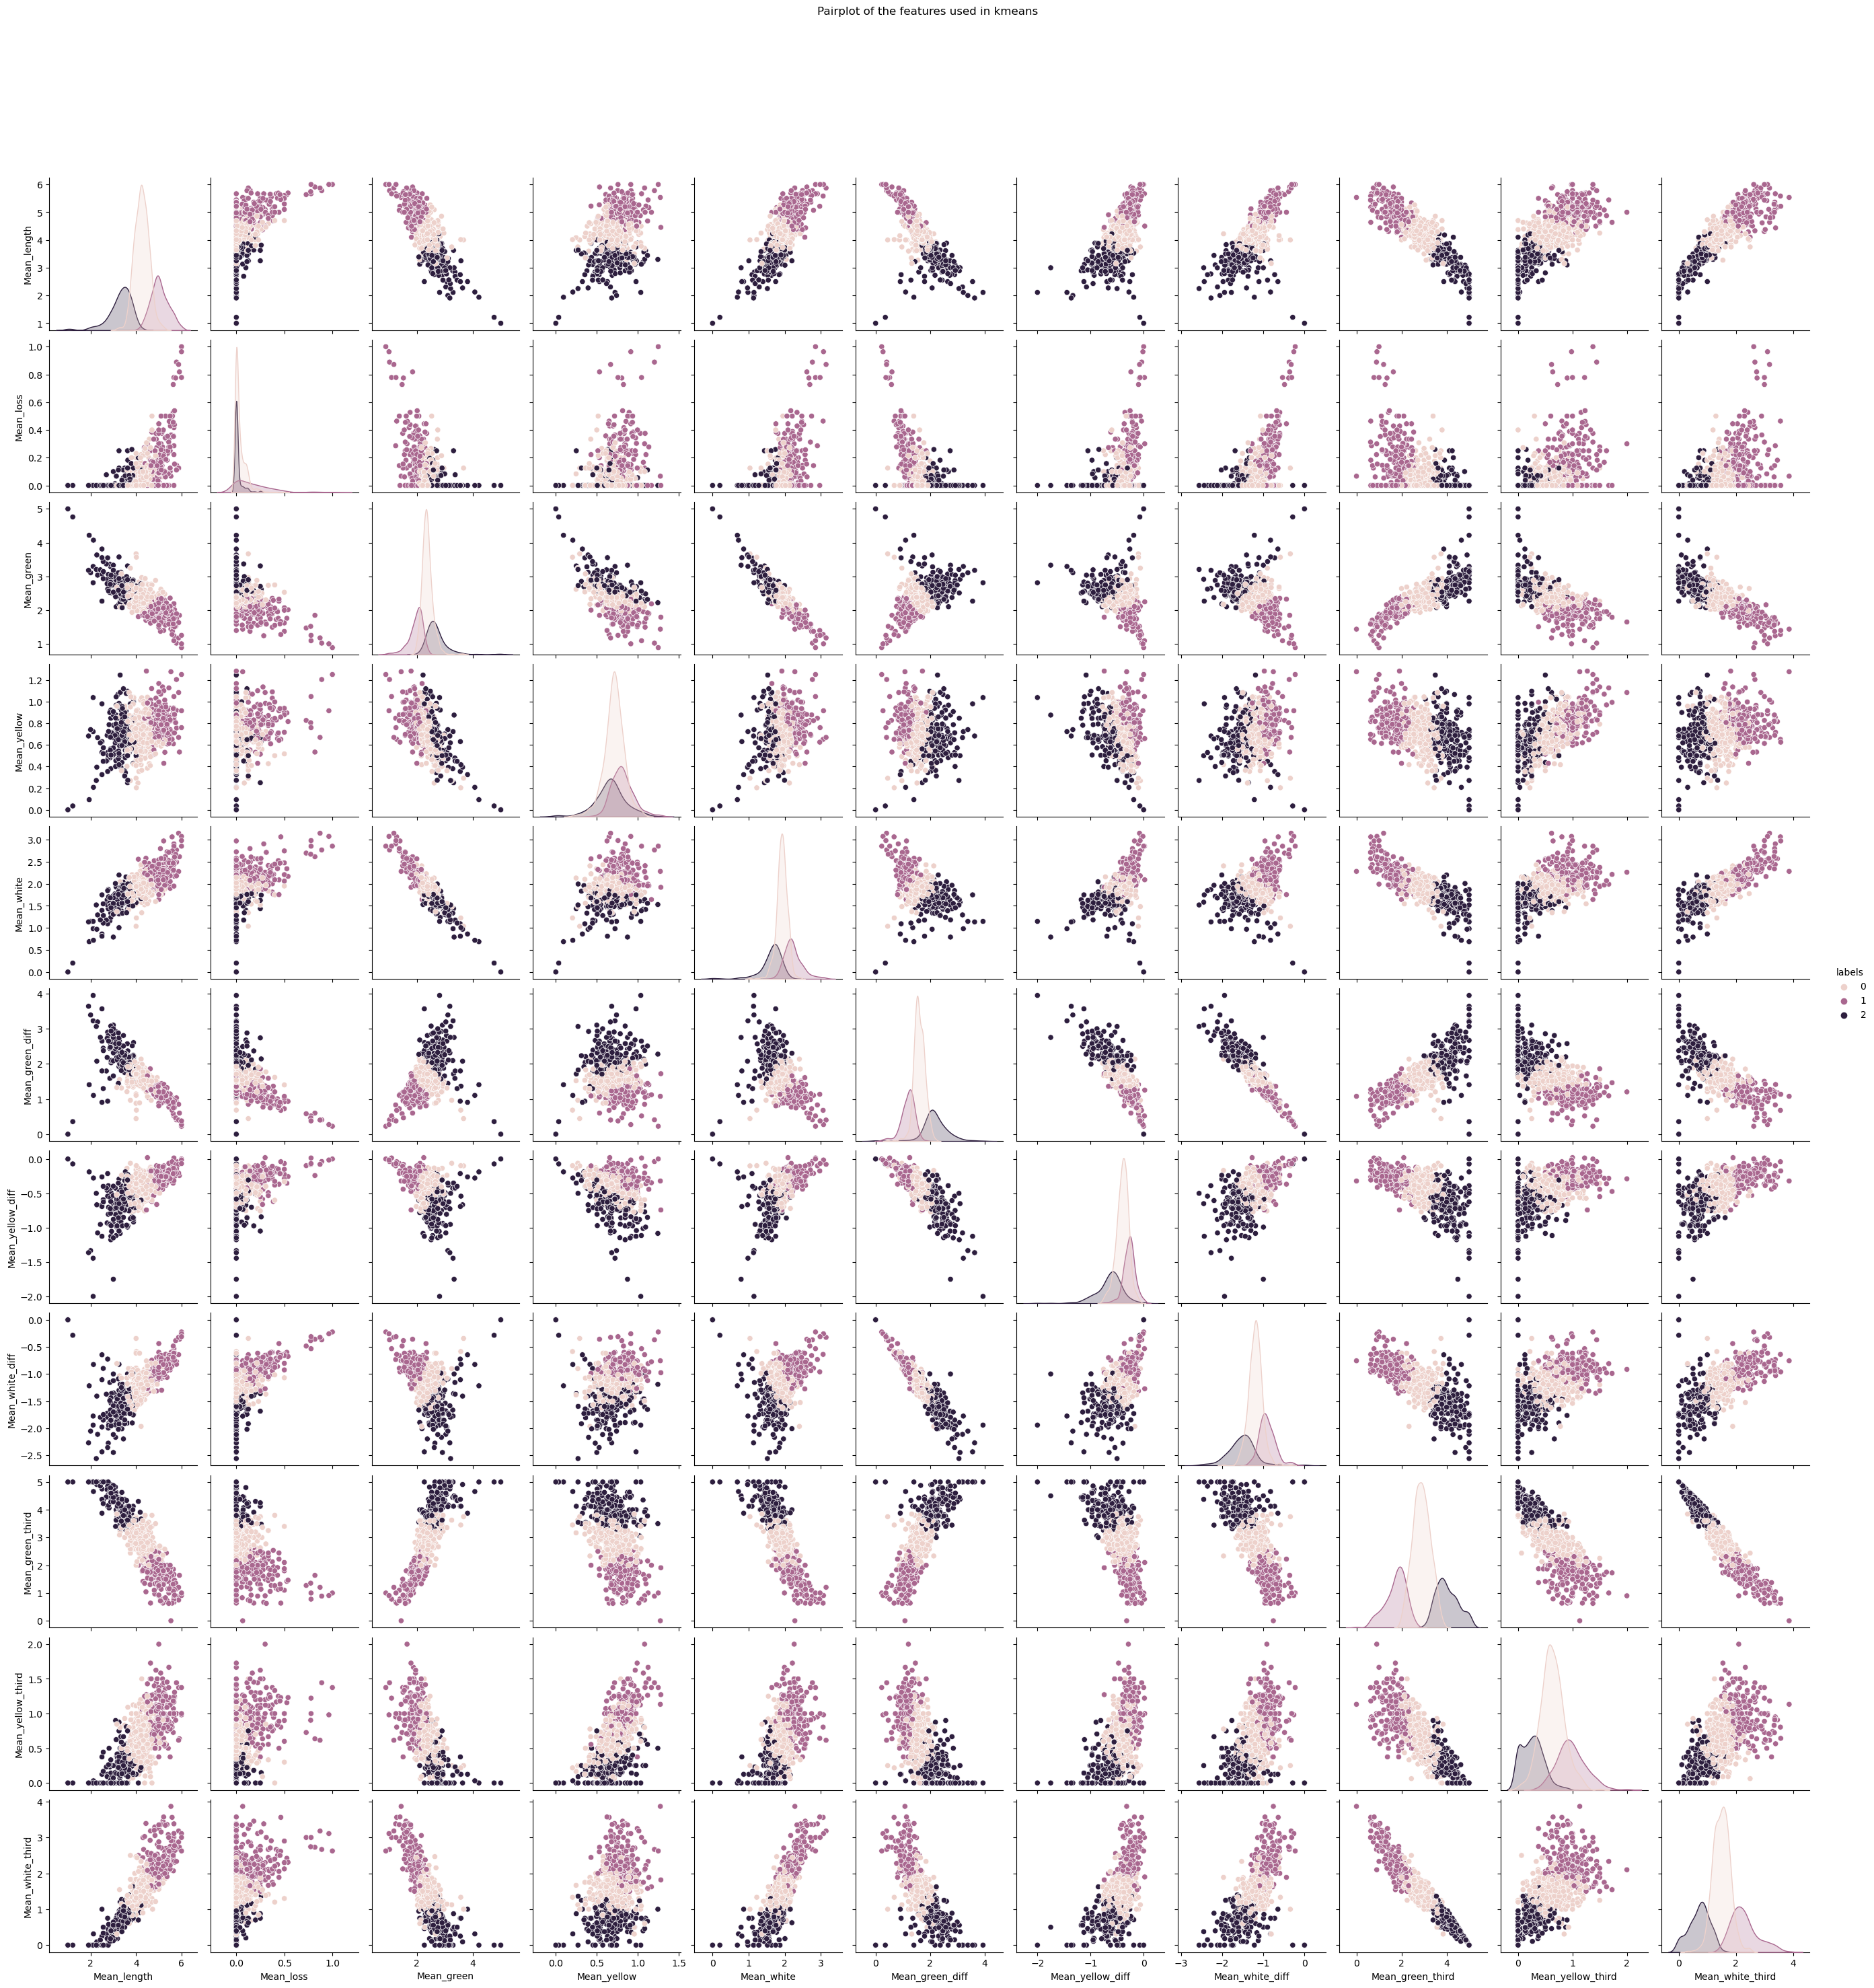

In [98]:
pair = sns.pairplot(data = features.sample(1000), hue = 'labels')
pair.fig.suptitle("Pairplot of the features used in kmeans", y=1.08) # y= some height>1
plt.show()

In [99]:
fig = px.scatter_3d(features.sample(500), x = 'Mean_white_diff', y = 'Mean_green_diff', 
                    z = 'Mean_yellow_diff', color = 'labels', title = 'Scatterplot of the mean difference')
fig.update_traces(marker_size = 5)
fig.show()

In [102]:
fig = px.scatter_3d(features.sample(500), x = 'Mean_length', y = 'Mean_green_third', 
                    z = 'Mean_yellow_third', color = 'labels',  title = 'Scatterplot of the average number of tiles')
fig.update_traces(marker_size = 5)
fig.show()

### Creating a new variable for evaluating performance

Since our results aren't the most revealing we will try to infer more information from the games, in particular, we will calculate de average percentage of possible words discarted by each guess.

In [107]:
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

def check_words(input_word ,target):
    input_word = input_word.lower()
    target = target.lower()
    sequence = ['⬜']*5
    selected = [False]*5
    for i in range(0,5):
        if input_word[i] == target[i]:
            sequence[i] = '🟩'
            selected[i] = True
    for i in range(0,5):
        if input_word[i] != target[i]:
            indexes = find(target, input_word[i])
            for index in indexes:
                if not selected[index]:
                    selected[index] = True
                    sequence[i] = '🟨'
                    break
    aux = ""
    return aux.join(sequence)

def set_of_words(possible_inputs, target):
    result = set()
    for word in possible_inputs:
        result.add(check_words(word, target))
    return result

#set of valid words
valid_inputs = []
with open("valid-wordle-words.txt") as f:
    valid_inputs = f.read().splitlines()
    
#dictionary of games and target words
game_dict = {}
with open("wordle-words-by-day2.txt") as f:
    for line in f:
        line = line.strip()
        game_dict.update({int(line[0:3]) : line[4::]})

posible_games = {}
for i in range(196, 516):
    posible_games.update({i:set_of_words(valid_inputs, game_dict[i])})

In [109]:
#Not needed but may be useful in the future
posible_combinations = []
with open("wordle-words-by-day2.txt") as f:
    for line in f:
        line = line.strip()
        pattern_dict = {}
        word = line[4::]
        for attempt in valid_inputs:
            pattern = check_words(attempt, word)
            pattern_dict[pattern] = pattern_dict.get(pattern, set()).union({attempt})
        posible_combinations.append(pattern_dict)

In [111]:
posible_combinations[0]

{'⬜⬜⬜🟨⬜': {'aahed',
  'acari',
  'ached',
  'ackee',
  'acned',
  'acorn',
  'acted',
  'added',
  'admen',
  'adobo',
  'adorn',
  'advew',
  'adzed',
  'afara',
  'agast',
  'aggri',
  'aggro',
  'aggry',
  'agism',
  'agist',
  'aglee',
  'aglet',
  'agley',
  'agora',
  'aided',
  'ailed',
  'aimed',
  'ainee',
  'aiyee',
  'alarm',
  'alary',
  'aldea',
  'alibi',
  'alien',
  'alist',
  'allee',
  'allel',
  'alley',
  'almeh',
  'aloed',
  'amort',
  'amped',
  'andro',
  'angel',
  'angry',
  'angst',
  'annex',
  'anted',
  'antra',
  'antsy',
  'apart',
  'apish',
  'apism',
  'apnea',
  'aport',
  'appel',
  'appro',
  'apted',
  'avast',
  'aviso',
  'award',
  'awarn',
  'awash',
  'awmry',
  'awned',
  'awork',
  'axled',
  'axmen',
  'caaed',
  'cadee',
  'cadet',
  'caged',
  'cagey',
  'caird',
  'cairn',
  'caked',
  'cakey',
  'camel',
  'cameo',
  'caned',
  'caneh',
  'canso',
  'canst',
  'caped',
  'capex',
  'capri',
  'caved',
  'cavel',
  'cawed',
  'chara',
 

In [123]:
most_likely = []
with open("wordle-words-by-day2.txt") as f:
    for line in f:
        line = line.strip()
        pattern_dict = {}
        word = line[4::]
        for attempt in valid_inputs:
            value = word_frequency(attempt, 'en')
            pattern = check_words(attempt, word)
            if pattern_dict.get(pattern, "") == "" or word_frequency(pattern_dict[pattern], 'en') < value:
                    pattern_dict[pattern] = attempt
        most_likely.append(pattern_dict)

In [124]:
most_likely[0]

{'⬜⬜⬜🟨⬜': 'money',
 '⬜⬜⬜⬜⬜': 'which',
 '⬜⬜🟨⬜⬜': 'would',
 '⬜🟨⬜⬜⬜': 'wrong',
 '⬜🟨⬜⬜🟩': 'cross',
 '⬜🟨⬜🟨🟨': 'outer',
 '⬜🟨⬜🟨⬜': 'order',
 '⬜🟨⬜⬜🟨': 'quite',
 '⬜⬜🟩⬜🟩': 'abbas',
 '⬜⬜🟩🟨⬜': 'label',
 '⬜⬜🟩🟨🟩': 'vibes',
 '⬜⬜🟩⬜⬜': 'habit',
 '⬜🟨🟨⬜⬜': 'great',
 '⬜🟨🟨⬜🟨': 'curve',
 '⬜🟨🟨🟨🟩': 'cures',
 '⬜🟨🟨⬜🟩': 'guess',
 '⬜🟨⬜🟨🟩': 'tries',
 '⬜🟨⬜🟩⬜': 'about',
 '⬜🟨🟨🟨⬜': 'trust',
 '⬜🟨🟨🟨🟨': 'abuse',
 '⬜⬜⬜⬜🟩': 'class',
 '⬜⬜🟨🟨🟨': 'house',
 '⬜⬜🟨🟨🟩': 'hours',
 '⬜⬜⬜⬜🟨': 'while',
 '⬜⬜⬜🟨🟩': 'times',
 '⬜⬜⬜🟨🟨': 'other',
 '⬜⬜🟨🟨⬜': 'there',
 '⬜⬜🟨⬜🟩': 'works',
 '⬜⬜🟨⬜🟨': 'their',
 '⬜⬜🟨🟩⬜': 'forum',
 '⬜🟩⬜⬜⬜': 'level',
 '⬜🟩⬜⬜🟩': 'means',
 '⬜🟩🟨⬜⬜': 'jerry',
 '⬜🟩🟨⬜🟩': 'terms',
 '⬜🟩🟨⬜🟨': 'perdu',
 '⬜⬜⬜🟩⬜': 'awful',
 '⬜⬜⬜🟩🟩': 'focus',
 '⬜⬜🟩🟩⬜': 'album',
 '⬜⬜🟩🟨🟨': 'fiber',
 '⬜⬜🟩⬜🟨': 'table',
 '⬜⬜⬜🟩🟨': 'value',
 '⬜🟨🟩⬜🟩': 'pubis',
 '⬜🟨🟩⬜⬜': 'orbit',
 '⬜🟨⬜🟩🟩': 'argus',
 '⬜🟨⬜🟩🟨': 'issue',
 '🟨⬜⬜🟨⬜': 'every',
 '🟨⬜⬜⬜🟩': 'books',
 '⬜⬜🟩🟩🟩': 'babus',
 '🟨⬜⬜⬜⬜': 'still',
 '🟨⬜⬜⬜🟨': 'state',
 '🟨⬜🟨⬜🟩': 'birds',
 '🟨⬜⬜🟩🟩': 'bonus',
 '🟨⬜⬜🟩⬜': 's

In [160]:
def find_reduction(input_word, pattern):
    count = 0
    for word in valid_inputs:
        if pattern == check_words(input_word, word):
            count +=1
    return 1-count/12972.

In [161]:
#Precalculate the reduction for each value
reduc_values = []
for patterns in most_likely:
    pattern = {key:find_reduction(value, key) for key, value in patterns.items()}
    reduc_values.append(pattern)

In [164]:
def get_reduc(series, game):
    if len(series) == 1:
        return 1
    total = 0
    for attempt in series:
        if attempt != '🟩🟩🟩🟩🟩':
            total +=  reduc_values[game-196][attempt]
    if len(series) == 6 and series[-1] != '🟩🟩🟩🟩🟩':
        return total/(len(series))
    else:
        return total/(len(series)-1)
training_data['mean_reduct'] = training_data.apply(lambda x : get_reduc(x.processed_text, x.Game), axis = 1)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9916\3084211288.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
training_data

index  level_0  Game  Trial         Username  \
7              7        7   196      1       protensity   
11            11       11   196      1  VirtualDionysus   
14            14       14   196      1       MrsLouise4   
22            22       22   196      2      Flystreaker   
23            23       23   196      2   GoldSarcasmium   
...          ...      ...   ...    ...              ...   
6923123  6923123  6954101   515      7     moona_moony_   
6923124  6923124  6954102   515      7       JonMDexter   
6923125  6923125  6954103   515      7       KuronaNuva   
6923126  6923126  6954104   515      7           KZYONE   
6923127  6923127  6954105   515      7       Robtrinity   

                                     processed_text target  attemps  ocurr  \
7                                           [🟩🟩🟩🟩🟩]  REBUS        1     14   
11                                          [🟩🟩🟩🟩🟩]  REBUS        1     13   
14                                          [🟩🟩🟩🟩🟩]  REBUS        1     46   
22                                   [⬜⬜🟨🟨🟩, 🟩🟩🟩🟩🟩]  REBUS        2     22   
23                                   [⬜⬜🟨⬜⬜, 🟩🟩🟩🟩🟩]  REBUS        2     79   
...                                             ...    ...      ...    ...   
6923123  [🟨⬜⬜⬜🟨, ⬜🟨🟨⬜⬜, ⬜⬜🟨🟨🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]  BAKER        6     20   
6923124  [⬜⬜⬜⬜🟩, ⬜⬜⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩🟩🟩🟩, ⬜🟩🟩🟩🟩]  BAKER        6     15   
6923125  [⬜🟨🟨⬜🟨, 🟨🟩🟨⬜⬜, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]  BAKER        6     26   
6923126  [🟨🟨🟨⬜⬜, ⬜🟨🟨🟨⬜, ⬜⬜🟨🟨🟨, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]  BAKER        6     17   
6923127  [⬜⬜🟨⬜⬜, ⬜🟨🟨⬜🟨, 🟨🟩⬜🟩⬜, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]  BAKER        6     46   

         mean_reduct  
7           1.000000  
11          1.000000  
14          1.000000  
22          0.992754  
23          0.929001  
...              ...  
6923123     0.981794  
6923124     0.989644  
6923125     0.991623  
6923126     0.987383  
6923127     0.981113  

[5189349 rows x 10 columns]

In [169]:
aux = np.asarray(reduc_values)
np.save('reduc_values.npy' , aux)

In [177]:
uservals['Mean_reduc'] = training_data.groupby('Username')['mean_reduct'].mean().values

In [179]:
uservals.corr()

Mean_length  Mean_loss  Mean_green  Mean_yellow  \
Mean_length           1.000000   0.482679   -0.745821     0.295848   
Mean_loss             0.482679   1.000000   -0.363484     0.110959   
Mean_green           -0.745821  -0.363484    1.000000    -0.591452   
Mean_yellow           0.295848   0.110959   -0.591452     1.000000   
Mean_white            0.749576   0.383319   -0.899487     0.179675   
Mean_green_diff      -0.804946  -0.443787    0.461102    -0.075474   
Mean_yellow_diff      0.639532   0.294183   -0.388522    -0.201238   
Mean_white_diff       0.751935   0.453911   -0.415795     0.246479   
Mean_green_third     -0.892078  -0.376660    0.809317    -0.378637   
Mean_yellow_third     0.678570   0.258703   -0.665059     0.577416   
Mean_white_third      0.869393   0.381686   -0.762772     0.217028   
Mean_reduc           -0.275694  -0.054339    0.547301    -0.036409   

                   Mean_white  Mean_green_diff  Mean_yellow_diff  \
Mean_length          0.749576        -0.804946          0.639532   
Mean_loss            0.383319        -0.443787          0.294183   
Mean_green          -0.899487         0.461102         -0.388522   
Mean_yellow          0.179675        -0.075474         -0.201238   
Mean_white           1.000000        -0.521641          0.583041   
Mean_green_diff     -0.521641         1.000000         -0.814707   
Mean_yellow_diff     0.583041        -0.814707          1.000000   
Mean_white_diff      0.373701        -0.920531          0.523425   
Mean_green_third    -0.782178         0.778560         -0.624161   
Mean_yellow_third    0.498468        -0.588323          0.474414   
Mean_white_third     0.812969        -0.760810          0.608480   
Mean_reduc          -0.647972         0.176354         -0.331930   

                   Mean_white_diff  Mean_green_third  Mean_yellow_third  \
Mean_length               0.751935         -0.892078           0.678570   
Mean_loss                 0.453911         -0.376660           0.258703   
Mean_green               -0.415795          0.809317          -0.665059   
Mean_yellow               0.246479         -0.378637           0.577416   
Mean_white                0.373701         -0.782178           0.498468   
Mean_green_diff          -0.920531          0.778560          -0.588323   
Mean_yellow_diff          0.523425         -0.624161           0.474414   
Mean_white_diff           1.000000         -0.723519           0.544868   
Mean_green_third         -0.723519          1.000000          -0.806398   
Mean_yellow_third         0.544868         -0.806398           1.000000   
Mean_white_third          0.708001         -0.950553           0.582865   
Mean_reduc               -0.035510          0.425233          -0.243094   

                   Mean_white_third  Mean_reduc  
Mean_length                0.869393   -0.275694  
Mean_loss                  0.381686   -0.054339  
Mean_green                -0.762772    0.547301  
Mean_yellow                0.217028   -0.036409  
Mean_white                 0.812969   -0.647972  
Mean_green_diff           -0.760810    0.176354  
Mean_yellow_diff           0.608480   -0.331930  
Mean_white_diff            0.708001   -0.035510  
Mean_green_third          -0.950553    0.425233  
Mean_yellow_third          0.582865   -0.243094  
Mean_white_third           1.000000   -0.456624  
Mean_reduc                -0.456624    1.000000

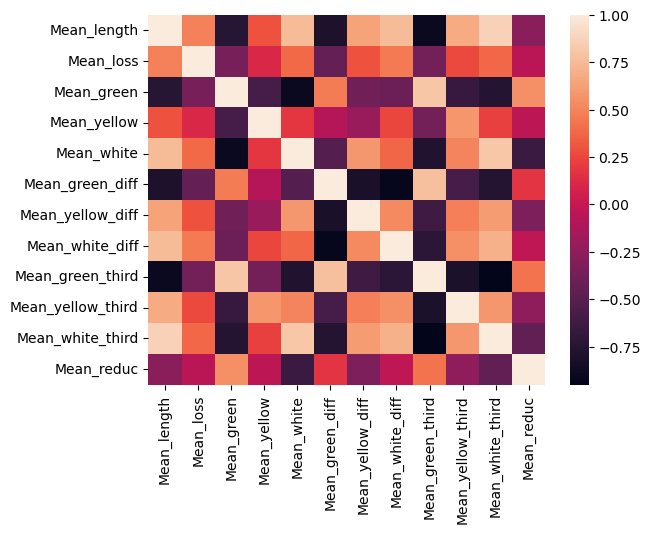

In [181]:
sns.heatmap(uservals.corr());

#### Performing a PCA with the new variable

In [186]:
features = uservals.loc[:, uservals.columns != 'Username']

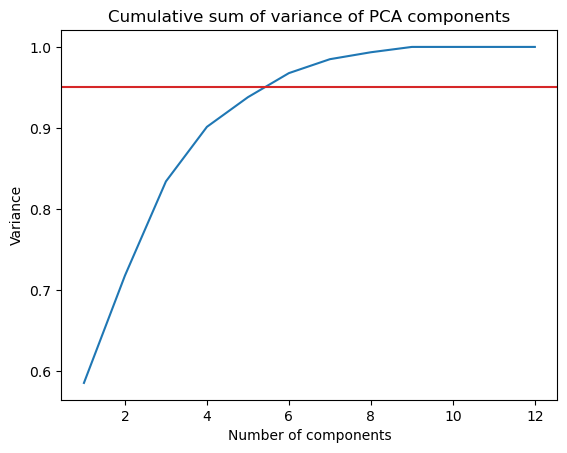

In [187]:
from sklearn.decomposition import PCA
pca = PCA(random_state = 123)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca.fit(scaled_features)
variance_ratio = sns.lineplot(x=range(1,len(features.columns)+1), y = pca.explained_variance_ratio_.cumsum());
variance_ratio.set_xlabel("Number of components")
variance_ratio.set_title("Cumulative sum of variance of PCA components");
variance_ratio.set_ylabel("Variance");
plt.axhline(0.95, color='#d62728');

As we can see we have to take up to 5 components in order to preserve 0.95 of the variance.

In [188]:
#features = uservals.loc[:, uservals.columns != 'Username']
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 123}

#### Clustering for 5 components

In [189]:
features = pca.transform(scaled_features)
features = pd.DataFrame(features)
features = features[[0,1,2,3,4]]

In [190]:
sse = []
silhouette_coefficients = []
for i in range(2,10):
    print('----Training for ' + str(i) + ' clusters----')
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    print('Silhoute: ' + str(score))
    print('Inertia: ' + str(kmeans.inertia_))

----Training for 2 clusters----
Silhoute: 0.29854937488910827
Inertia: 1115634.539308052
----Training for 3 clusters----
Silhoute: 0.28547758358329395
Inertia: 881329.6013452262
----Training for 4 clusters----
Silhoute: 0.22121873501030428
Inertia: 779077.2172325121
----Training for 5 clusters----
Silhoute: 0.20677141105951707
Inertia: 718591.3211783633
----Training for 6 clusters----
Silhoute: 0.204791305664462
Inertia: 663357.3122084208
----Training for 7 clusters----
Silhoute: 0.1895718767785736
Inertia: 610787.73741032
----Training for 8 clusters----
Silhoute: 0.18437402285584173
Inertia: 570751.676079228
----Training for 9 clusters----
Silhoute: 0.18059355387627088
Inertia: 538251.9938888424


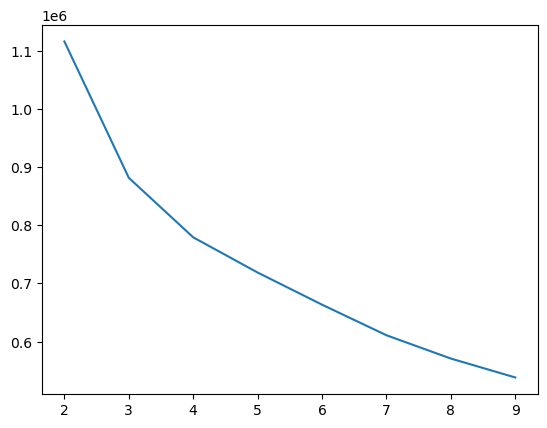

In [191]:
sns.lineplot(x = range(2,10), y = sse)
plt.show()

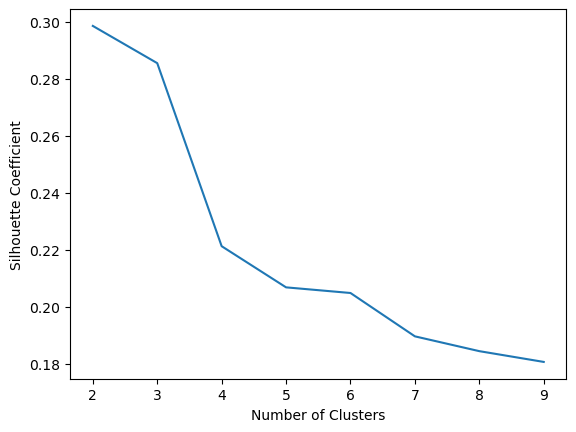

In [192]:
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### Clustering for 3

In [193]:
features = features[[0,1,2]]

In [ ]:
sse = []
silhouette_coefficients = []
for i in range(2,10):
    print('----Training for ' + str(i) + ' clusters----')
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    print('Silhoute: ' + str(score))
    print('Inertia: ' + str(kmeans.inertia_))

----Training for 2 clusters----
Silhoute: 0.334558804362522
Inertia: 925182.8457999442
----Training for 3 clusters----
Silhoute: 0.31916932705884665
Inertia: 698189.069353903
----Training for 4 clusters----
Silhoute: 0.25238602843268276
Inertia: 604382.9353016571
----Training for 5 clusters----
Silhoute: 0.24158833090114856
Inertia: 550113.2826909298
----Training for 6 clusters----


In [ ]:
sns.lineplot(x = range(2,10), y = sse)
plt.show()

In [ ]:
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### Clustering with 2 components

In [ ]:
features = features[[0,1]]

In [ ]:
sse = []
silhouette_coefficients = []
for i in range(2,10):
    print('----Training for ' + str(i) + ' clusters----')
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    print('Silhoute: ' + str(score))
    print('Inertia: ' + str(kmeans.inertia_))

In [ ]:
sns.lineplot(x = range(2,10), y = sse)
plt.show()

In [ ]:
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### Clustering without PCA

In [ ]:
features = uservals[['Mean_length', 'Mean_loss', 'Mean_yellow', 'Mean_white', 'Mean_yellow_diff',
                    'Mean_white_diff', 'Mean_yellow_third', 'Mean_reduc']]

In [ ]:
features.corr()

In [ ]:
sns.heatmap(features.corr());

In [ ]:
#features = uservals.loc[:, uservals.columns != 'Username']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 123}

In [ ]:
sse = []
silhouette_coefficients = []
for i in range(2,7):
    print('----Training for ' + str(i) + ' clusters----')
    kmeans = KMeans(n_clusters = i, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    print('Silhoute: ' + str(score))
    print('Inertia: ' + str(kmeans.inertia_))

In [ ]:
sns.lineplot(x = range(2,7), y = sse)
plt.show()

In [ ]:
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()